#  图像处理课程大作业：车票二维码检测与识别
####  刘文涛 1700011026 热合玛 1700017843 
---  
## 分工情况 
车票票面检测、车票二维码定位与分割：刘文涛  
二维码图像增强与识别：热合玛、刘文涛
## 算法目的与应用
该算法能够从一张车票的扫描图像中，扫描出车票上的二维码内容  
在复杂场景下，车票的扫描图像可能存在旋转、变形、噪点多、明暗不一致等问题  
从而降低了二维码扫描的成功率和准确度  
该算法利用车票扫描图片的一些特点以及车票本身的结构等信息  
从车票扫描图片中识别出车票的位置，并通过透视变换将车票摆正  
再根据二维码在车票上分布具备的一些特点，找到车票上二维码的位置，将二维码的部分截取出来  
而后在通过滤波、降噪、锐化、形态学运算等方式进行图像增强  
最后在对其进行二维码的识别  
通过以上过程，起到提高二维码识别成功率和准确度的作用  
## 算法流程展示

In [1]:
%matplotlib inline
import cv2
import numpy as np
import math
from functools import cmp_to_key
from pyzbar import pyzbar
from matplotlib import pyplot as plt

### 待处理的图片样例

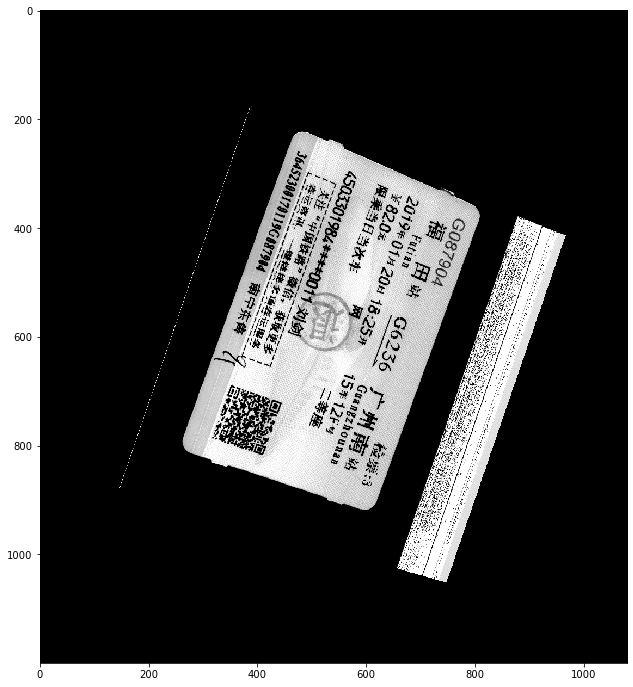

In [2]:
img = cv2.imread('train/0050.bmp',cv2.IMREAD_COLOR)
plt.figure(figsize=(12,12))
plt.imshow(img)
plt.show()

### Task 1 车票票面检测
在图像中找出车票所在的区域
#### 1.1 取出车票票面轮廓
先对原图做Ostu做阈值处理  
再从二值化的图像中找到面积最大的轮廓，并得到该轮廓的最小外接矩形  
用该外接矩形作mask剔除车票以外的部分  
并对取出的图案作闭操作，去除车票内的纹路

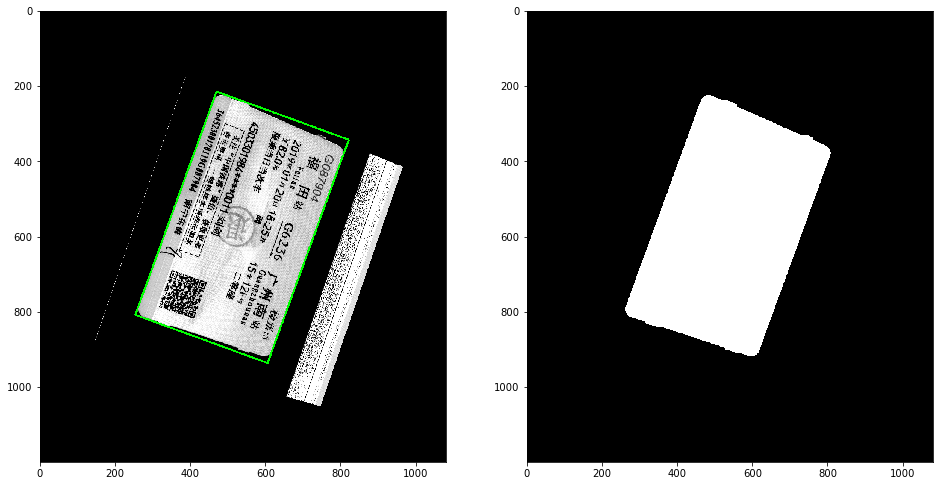

In [3]:
# 找到面积最大的轮廓的外接矩形，minArea为True时，矩形可以是倾斜的，否则是正的
def max_contours(thresh,minArea = True):
    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[0] if len(contours) == 2 else contours[1]
    areas = []
    for i in range(len(contours)):
        areas.append(cv2.contourArea(contours[i]))
    max_id = areas.index(max(areas))
    cnt = contours[max_id]
    if minArea:
        rect = cv2.minAreaRect(cnt)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        return box
    else:
        rect = cv2.boundingRect(cnt)
        return rect
    return None
imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
box = max_contours(thresh)
tmp_img = img.copy()
cv2.polylines(tmp_img,[box], True,(0,255,0), 3)
mask = np.zeros(thresh.shape,dtype=np.uint8)
cv2.fillPoly(mask,[box],(255))
thresh = cv2.add(thresh,np.zeros(thresh.shape,dtype=np.uint8),mask=mask)# 去除票面以外的图案
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5, 5))
thresh = cv2.morphologyEx(thresh,cv2.MORPH_CLOSE,kernel,iterations=5)# 闭操作去除纹路
plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(tmp_img)
plt.subplot(122)
plt.imshow(thresh,cmap='gray')
plt.show()

#### 1.2 对票面做透视变换
先用霍夫变换找到图片中的直线  
合并相似的直线，直到只剩4条直线（对应图像的四条边）  
求出这些直线的交点，这些交点即为票面的四个顶点  
对这四个顶点进行排序，从长边开始，顺时针方向排列  
根据排列好的四个顶点对票面做透视变换，变换成矩形  

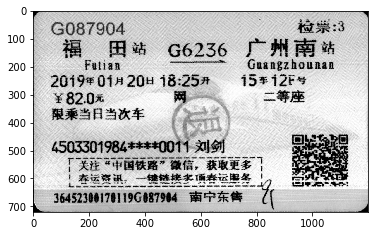

In [4]:
# 票面的目标长宽
ticket_w=1200
ticket_h=720
# 找到轮廓的四个顶点，找不到四个顶点时返回None
def get_points(img,bound=20):
    points = None
    # 霍夫变换找直线
    edges = cv2.Canny(img,50,150,3)
    lines = cv2.HoughLinesP(edges,1,np.pi/180,30,minLineLength=80,maxLineGap=50)
    if lines is not None:
        line_arg=[]
        for i in range(len(lines)):
            x1,y1,x2,y2=lines[i,0]
            flag=True
            for j in range(len(line_arg)):# 当有直线和当前线段两个端点距离近时，认为这两条是同一条直线
                k,b=line_arg[j]
                if k==1e10 and abs(x1-b)+abs(x2-b)<bound:
                    flag=False
                    break
                if abs((k*x1+b-y1)/math.sqrt(1+k**2))+abs((k*x2+b-y2)/math.sqrt(1+k**2))<bound:
                    flag=False
                    break
            if not flag:
                continue
            k=1e10 if x1==x2 else (y1-y2)/(x1-x2)# 斜率为无限大时，k=1e10, b=x
            b=x1 if x1==x2 else y2-x2*k
            line_arg.append([k,b])
        line_arg.sort(key=lambda x:(abs(x[0])if x[0]<-3 else x[0]))# 对直线根据斜率排序，确保长、宽分别在前后两条直线中
        if len(line_arg)==4:
            points=[]
            for i in range(2):# 寻找长与宽的交点
                k,b=line_arg[i]
                for j in range(2,4):
                    k1,b1=line_arg[j]
                    x=b1 if k1==1e10 else (b1-b)/(k-k1)
                    y=k*x+b
                    points.append([x,y])
            points=np.int0(points)
    return points
# 将顶点按顺时针方向排序
def clockwise_sort(points):
    points = points[np.argsort(points[:,0]+points[:,1])]
    p0 = points[0]
    def crossprod_cmp(p1,p2):# 利用叉乘的正负号判断次序
        v1 = p1-p0
        v2 = p2-p0
        return v1[1]*v2[0]-v1[0]*v2[1]
    points[1:]=np.array(sorted(points[1:],key=cmp_to_key(crossprod_cmp)),dtype=np.uint32)
    return points
points = get_points(thresh)
if points is not None:# 若找不到四个顶点，则根据外接矩形的顶点做透视变换
    box = points
box = clockwise_sort(box)
if np.linalg.norm(box[1]-box[0])<np.linalg.norm(box[2]-box[1]):# 保证第一条边是长边
    box=np.concatenate((box[1:],box[:1]))
box = box.astype(np.float32)
target=np.array([[0,0],[ticket_w,0],[ticket_w,ticket_h],[0,ticket_h]],dtype=np.float32)
matrix = cv2.getPerspectiveTransform(box,target)
perspective_img = cv2.warpPerspective(img,matrix,(ticket_w, ticket_h))
plt.imshow(perspective_img)
plt.show()

#### 1.3 将票面摆正
根据二维码的位置判断当前的票面的正反  
若票面是反的，则需要将票面旋转180度

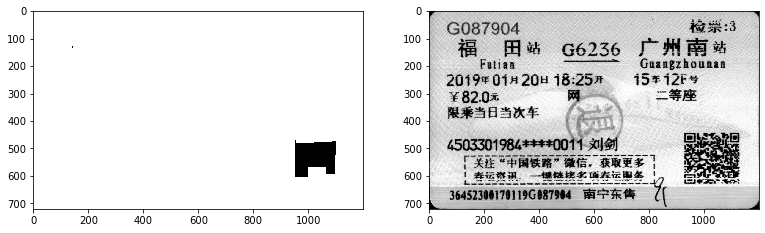

In [5]:
# 预估的二维码大致分布范围
code_w_b=int(ticket_w/10*3)
code_w_e=5
code_h_b=int(ticket_h/15*7)
code_h_e=50
imgray = cv2.cvtColor(perspective_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 32, 255, cv2.THRESH_BINARY)  # 二值化
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))  # 先用较小的kernel做侵蚀，将二维码连成一片
thresh = cv2.erode(thresh,kernel,iterations=4)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))  # 再用较大的kernel做膨胀，去除其他纹路
thresh = cv2.dilate(thresh,kernel,iterations=4)
# 对比左上角和右下角哪个的灰度值之和更小，若左上角更小，则将图像旋转180度
if np.sum(thresh[code_h_e:code_h_b,code_w_e:code_w_b])<np.sum(thresh[-code_h_b:-code_h_e,-code_w_b:-code_w_e]):
    M = cv2.getRotationMatrix2D((ticket_w * 0.5, ticket_h * 0.5), 180, 1)
    perspective_img = cv2.warpAffine(perspective_img, M,(ticket_w, ticket_h))
plt.figure(figsize=(13,13))
plt.subplot(121)
plt.imshow(thresh,cmap='gray')
plt.subplot(122)
plt.imshow(perspective_img)
plt.show()

### Task 2 车票二维码定位与分割
#### 2.1 找到二维码的大致区域
根据二维码在票面上分布的位置，截取出二维码大致分布的区域  
对二维码图像做较为粗糙的开闭运算，去除外部纹路等，得到一个二维码部分的mask  
用该mask取出二维码，剔除其余纹路  
接着再对取出的二维码做更精细的开闭运算，得到二维码的精确边界轮廓  

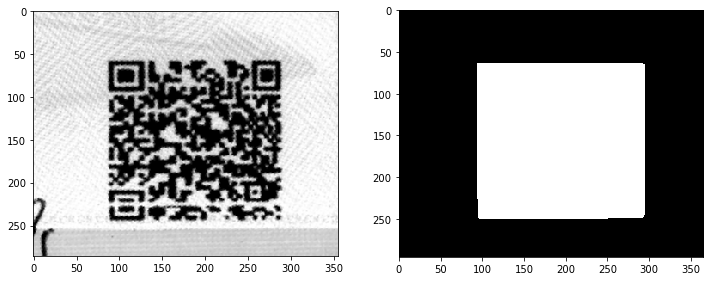

In [6]:
qr_img = perspective_img[-code_h_b:-code_h_e, -code_w_b:-code_w_e]# 截出二维码的大致区域并二值化
imgray = cv2.cvtColor(qr_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
thresh1 = cv2.bitwise_not(thresh)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))# 用较小的kernel做闭运算，此时二维码连成一块
thresh = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel, iterations=5)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))# 用较大的kernel做开运算，此时其余图案被清除
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
box = max_contours(thresh)# 找到外接矩形，并用该外接矩形作mask取出二维码区域
mask = np.zeros(thresh.shape, dtype=np.uint8)
cv2.fillPoly(mask, [box], (255))
thresh = cv2.add(thresh1, np.zeros(thresh.shape, dtype=np.uint8), mask=mask)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))# 闭操作将二维码连成整块
thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=10)
thresh1 = np.zeros((thresh.shape[0] + 10, thresh.shape[1] + 10), dtype=np.uint8)# 将原本图像外接上边框为5的边缘，避免mask接触到边界找不到边
box = max_contours(thresh)
thresh1[5:-5, 5:-5] = thresh
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))# 由于此时已将二维码外部分取出，可以进行“粗犷”的闭操作，此后二维码基本变成方形
thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel, iterations=10)
plt.figure(figsize=(12,12))
plt.subplot(121)
plt.imshow(qr_img)
plt.subplot(122)
plt.imshow(thresh1,cmap='gray')
plt.show()

#### 2.2 对二维码做透视变换
与票面二维码的透视变换类似  
用霍夫变换找到直线并求出交点  
其中需要注意的是之前取出的边界mask有可能接触到图像边缘，因此需要为图像加上边界进行处理  
加上边界以后，直线的交点有可能位于图像的外部，需要对该情况进行判断

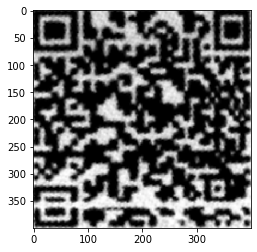

In [7]:
code_w=400
points = get_points(thresh1)# 通过霍夫变换找顶点，找不到的情况下直接用外接矩形
if points is not None:
    for i in range(len(points)):
        x, y = points[i] - 4
        x = 0 if x < 0 else x
        y = 0 if y < 0 else y
        box[i] = [x, y]
box = clockwise_sort(box)# 对四个点进行顺时针排序，并做透视变换
box = box.astype(np.float32)
target = np.array([[0, 0], [code_w, 0], [code_w, code_w], [0, code_w]], dtype=np.float32)
matrix = cv2.getPerspectiveTransform(box, target)
perspective_img = cv2.warpPerspective(qr_img, matrix, (code_w, code_w))
plt.imshow(perspective_img)
plt.show()

### Task 3 二维码图像增强与识别
#### 3.1 二值化二维码图像
先对二维码的图像进行初步处理  
及先将其转换为灰度图像  
用高斯滤波去除噪声后  
再用拉普拉斯变换增强边界  
而后再使用自适应二值化将其变成二值化图像

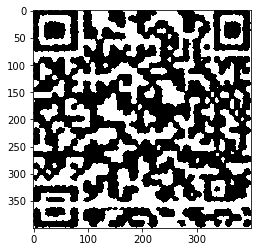

In [8]:
imgray = cv2.cvtColor(perspective_img, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(imgray, ksize = (5,5),sigmaX = 0, sigmaY = 0)
kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
lapimg = cv2.filter2D(blur, -1, kernel)
thresh = cv2.adaptiveThreshold(lapimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 0)
plt.imshow(thresh,cmap='gray')
plt.show()

经过该步变换后，先进行一次二维码识别  
若已能够识别出二维码内容  
则无需再进行后续操作  
到此为止能识别出train文件夹里58%的二维码
#### 3.2 调整变形
经观察，经过3.1后仍无法识别出的二维码大部分都是发生了一定变形  
从二维码的结构来看，其左上角、右上角、左下角有三个方形区域  
这三个部分是重要的定位点  
而这些无法识别出的二维码，其定位点大多被拉长成了长方形  
那么可以取出这些定位点，找到他们的轮廓并得到其长与宽  
以定位点的长与宽作为参考，对二维码进行分区伸缩  
将定位点重新变形成正方形  

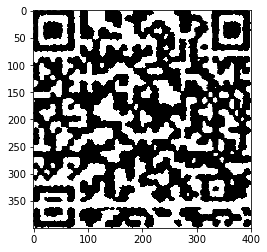

In [9]:
anchor_e = int(code_w / 4)# 估计定位点占二维码1/4
# 根据定位形状对二维码进行局部拉伸
def adjustAnchor(thresh, bound):
    img_h,img_w = thresh.shape
    u,d,l,r = bound
    l=l+img_w if l<0 else l
    r=r+img_w if r<0 else r
    thresh1 = cv2.bitwise_not(thresh)
    thresh2 = np.zeros(thresh.shape, dtype=np.uint8)
    thresh2[u:d,l:r] = thresh1[u:d,l:r]# 用mask取出定位点
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    thresh2 = cv2.morphologyEx(thresh2, cv2.MORPH_OPEN, kernel, iterations=2)# 开运算将定位点连成一片
    x,y,w,h = max_contours(thresh2, False)# 找到定位点的外接矩形
    img_w += h-w
    new_thresh = cv2.resize(thresh,(img_w,img_h))
    new_thresh[:,0:l]=thresh[:,0:l]
    new_thresh[:,l:l+h]=cv2.resize(thresh[:,l:l+w],(h,img_h))# 对定位点进行局部拉伸，使定位点变成正方形
    new_thresh[:,l+h:]=thresh[:,l+w:]
    return new_thresh
thresh = adjustAnchor(thresh,(0,anchor_e,0,anchor_e))# 以左上角定位点作为拉伸参考
thresh = adjustAnchor(thresh,(0,anchor_e,-anchor_e,-1))# 以右上角定位点作为拉伸参考
plt.imshow(thresh,cmap='gray')
plt.show()

经过局部拉伸后，二维码的定位点变成了正方形  
此时许多因为定位点变形的二维码都能够识别出来  
经过此步骤后，识别的准确率达到75%  
#### 3.3 二维码重绘
**3.3.1 行、列划分**  
经过以上调整仍然无法识别出来的二维码，说明存在较为严重的变形或者污染  
需要对二维码进行重新的分块和重绘  
可能是每一行的宽度不均匀所导致  
使用扫描线对二维码图像进行扫描，找到二维码的每一行  
而后根据每一行的平均颜色判断该行是黑色还是白色  
再根据每格的颜色将其重新填充到标准尺寸的网格中

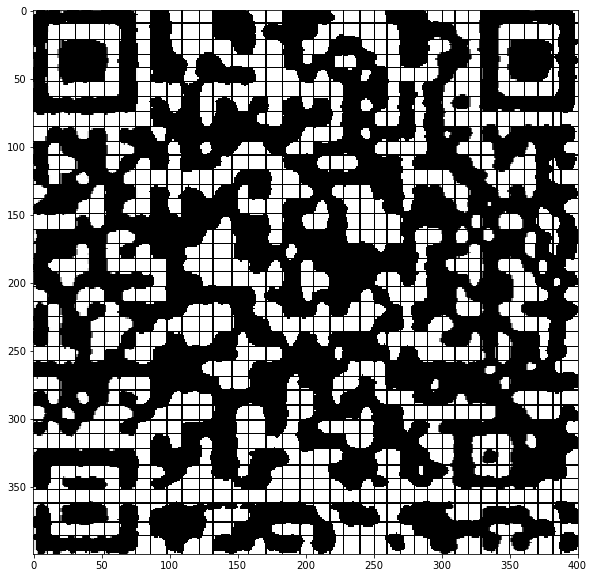

In [10]:
# 用直线扫描二维码，当相邻直线像素改变的数量较多时，认为是两行的分界
def found_point(mat, rows=True):
    temp1 = []
    i = 0
    normal_gap = 5
    last_gap = 0
    length = mat.shape[0] if rows else mat.shape[1]
    while i < length:
        if i + 11 < length:
            if i < length - 20:
                gap = normal_gap
            else:
                gap = last_gap
            if rows:
                point_row = Point(mat[int(i) + gap:min(int(i) + 18, 406), :], min(12, 406 - int(i)), rows)
            else:
                point_row = Point(mat[:, int(i) + gap:min(int(i) + 18, 406)], min(12, 406 - int(i)), rows)
            mat_temp = point_row + gap
        else:
            break
        if mat_temp is None:
            i = i + 11
        else:
            i = i + mat_temp
            temp1.append(i)
    return temp1
def Point(mat, border, rows):
    gap = 3
    result_array = []
    white_tmp_matrix = np.zeros((1, mat.shape[1]), np.int16) if rows else np.zeros((mat.shape[0], 1), np.int16)
    black_last_matrix = np.zeros((1, mat.shape[1]), np.int16) if rows else np.zeros((mat.shape[0], 1), np.int16)
    length = mat.shape[0] if rows else mat.shape[1] # 从白色点变为黑色点,白色连续线段超过2，下一个点为黑点
    for i in range(0, min(border, length)): # 循环所有列
        if i == 0:
            white_tmp_matrix = np.where(mat[i, :] == 255, 1, 0) if rows else np.where(mat[:, i] == 255, 1, 0)
        else:
            white_current_matrix = np.where(mat[i, :] == 255, 1, -1) if rows else np.where(mat[:, i] == 255, 1, -1)
            white_cal_matrix = white_tmp_matrix * white_current_matrix
            white_count_matrix = np.where(white_cal_matrix == -1, 1, 0)
            white_change_count = white_count_matrix.sum()# 变更tmp，将已经变化的点修改为0
            white_tmp_matrix = white_tmp_matrix * np.where(white_cal_matrix == -1, 0, 1)# j > gap宽度则计入计算
            if i > gap and white_change_count > 0:
                for k in range(0, white_change_count):
                    result_array.append(i - 1)
        if i == 0:
            black_last_matrix = np.where(mat[i, :] == 0, 1, 0) if rows else np.where(mat[:, i] == 0, 1, 0)
        else:
            black_current_matrix = np.where(mat[i, :] == 0, 5, 1) if rows else np.where(mat[:, i] == 0, 5, 1)
            black_cal_matrix = black_last_matrix + black_current_matrix # 统计上次为黑本次为白
            black_count_matrix = np.where(black_cal_matrix == 2, 1, 0)
            black_change_count = black_count_matrix.sum() # 变更tmp
            black_last_matrix = black_cal_matrix # 上次为白，本次为白，更新为0
            black_last_matrix = np.where(black_last_matrix == 1, 0, black_last_matrix) # 上次为黑，本次为白，更新为1000
            black_last_matrix = np.where(black_last_matrix == 2, 1000, black_last_matrix) # 上次为白，本次为黑，更新为1
            black_last_matrix = np.where(black_last_matrix == 5, 1, black_last_matrix) # 上次为黑，本次为黑，更新为1
            black_last_matrix = np.where(black_last_matrix == 6, 1, black_last_matrix)
            if i > gap and black_change_count > 0: # j > gap宽度则计入计算
                for k in range(0, black_change_count):
                    result_array.append(i - 1)
    result = max(int(np.median(np.array(result_array))), int((np.array(result_array).mean())))
    return result
point_rows = found_point(thresh)
point_columns = found_point(thresh, False)
if len(point_columns) == 37:
    point_columns.pop(36)
if len(point_rows) == 37:
    point_rows.pop(36)
tmp_img = thresh.copy()
for rowIndex in range(0, len(point_rows)):
    cv2.line(tmp_img, (0, point_rows[rowIndex]), (tmp_img.shape[1], point_rows[rowIndex]), (0), 1)
for colIndex in range(0, len(point_columns)):
    cv2.line(tmp_img, (point_columns[colIndex], 0), (point_columns[colIndex], tmp_img.shape[0]), (0), 1)
plt.figure(figsize=(10,10))
plt.imshow(tmp_img,cmap='gray')
plt.show()

**3.3.2 二维码重绘**  
最后根据这些网格中的平均灰度值判断该网格的颜色  
并将二维码重新绘制到标准尺寸网格中

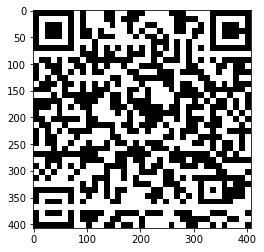

In [11]:
# 生成新的二维码
def generate_image(img, point_rows, point_columns):
    margin_offset = 0
    round_offset = 2
    gen_code = np.ones((407, 407), np.uint8)*255
    for i in range(-1, len(point_rows)-1):
        margin_offset = 0
        for j in range(-1, len(point_columns) - 1):
            start_x = 0 if j == -1 else point_columns[j]
            start_y = 0 if i == -1 else point_rows[i]
            end_x = point_columns[j + 1]
            end_y = point_rows[i + 1]
            avg_center = img[start_y + round_offset:end_y - round_offset,
                         start_x + round_offset:end_x - round_offset]
            avg_offset_3_center = img[start_y + round_offset:end_y - round_offset, start_x:start_x + 3]
            avg_total = img[start_y:end_y, start_x:end_x]
            avg_center_mean = avg_center.mean()
            avg_offset_3_center_mean = avg_offset_3_center.mean()
            avg_inner_round_mean = (avg_total.sum() - avg_center.sum()) / (
                    avg_total.shape[0] * avg_total.shape[1] - avg_center.shape[0] * avg_center.shape[1])
            # 如果整体判定为黑色，判断是否存在向右偏移的情况，当前格子的偏移将影响下一个格子的偏移情况
            if avg_center_mean < 50:
                current_offset = int(round(avg_offset_3_center_mean / 255.0 * 3))
                margin_offset = current_offset if margin_offset < current_offset else margin_offset
                if margin_offset == None:
                    margin_offset = 0
            if avg_center_mean < 50:
                gen_code[i * 11 + 11:i * 11 + 22, j * 11 + 11: j * 11 + 22] = 0  # 表示为黑色
            elif avg_center_mean > 150:# 中心点偏白判定为白色
                gen_code[i * 11 + 11:i * 11 + 22, j * 11 + 11: j * 11 + 22] = 255  # 表示为白色
            elif avg_center_mean > avg_inner_round_mean:
                gen_code[i * 11 + 11:i * 11 + 22, j * 11 + 11: j * 11 + 22] = 255  # 表示为白色
            else:
                gen_code[i * 11 + 11:i * 11 + 22, j * 11 + 11: j * 11 + 22] = 0
    return gen_code
point_rows.append(thresh.shape[0])
point_columns.append(thresh.shape[1])
gen_code = generate_image(thresh, point_rows, point_columns)
plt.imshow(gen_code, cmap='gray')
plt.show()

经过此步操作后，正确率变为97%  
  
**3.3.3 利用先验知识重构定位点和校验位**  
除此之外，考虑二维码本身特性  
所有二维码的定位点都相同  
并且在定位点之间连着黑白相间的校验点  
为避免这些点识别错误  
可以直接用先验知识将这些点画上

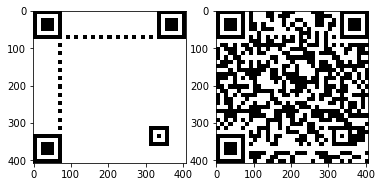

060879040277175190690921481193984908005424848195650020671997154259847660112086642161393870419124509193926867204662983591700417916680932623254009


In [12]:
# 根据先验知识画定位点和校验位
def fill_detect(image):
    image[0:77, 0:77] = 0# 重构左上定位点
    image[11:66, 11:66] = 255
    image[22:55, 22:55] = 0
    image[330:407, 0:77] = 0# 重构左下定位点
    image[341:396, 11:66] = 255
    image[352:385, 22:55] = 0
    image[0:77, 330:407] = 0# 重构右上定位点
    image[11:66, 341:396] = 255
    image[22:55, 352:385] = 0
    image[66:77, 77:330] = 255# 重构横向校验位
    image[66:77, 88:99] = 0
    image[66:77, 110:121] = 0
    image[66:77, 132:143] = 0
    image[66:77, 154:165] = 0
    image[66:77, 176:187] = 0
    image[66:77, 198:209] = 0
    image[66:77, 220:231] = 0
    image[66:77, 242:253] = 0
    image[66:77, 264:275] = 0
    image[66:77, 286:297] = 0
    image[66:77, 308:319] = 0
    image[77:330, 66:77] = 255# 重构纵向校验位
    image[88:99, 66:77] = 0
    image[110:121, 66:77] = 0
    image[132:143, 66:77] = 0
    image[154:165, 66:77] = 0
    image[176:187, 66:77] = 0
    image[198:209, 66:77] = 0
    image[220:231, 66:77] = 0
    image[242:253, 66:77] = 0
    image[264:275, 66:77] = 0
    image[286:297, 66:77] = 0
    image[308:319, 66:77] = 0
    image[308:363, 308:363] = 0# 重构右下小定位点
    image[319:352, 319:352] = 255
    image[330:341, 330:341] = 0
    return image
tmp_img = np.ones((407, 407), np.uint8)*255
fill_detect(tmp_img)
fill_detect(gen_code)
plt.subplot(121)
plt.imshow(tmp_img,cmap='gray')
plt.subplot(122)
plt.imshow(gen_code,cmap='gray')
plt.show()
barcodes = pyzbar.decode(gen_code)
text = barcodes[0].data.decode('utf-8') if len(barcodes)!=0 else ''
print(text)

其中填充的内容如上图所示  
经过该步骤后，准确率变为99%

## 各个模块和代码
### 车票票面检测
```python
def crop_ticket(img):
	# 找到轮廓
	imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	box = max_contours(thresh)
	mask = np.zeros(thresh.shape, dtype=np.uint8)
	cv2.fillPoly(mask, [box], (255))
	thresh = cv2.add(thresh, np.zeros(thresh.shape, dtype=np.uint8), mask=mask)
	# 闭操作去除无用纹路
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=5)
	points = get_points(thresh)
	if points is not None:
		box = points
	# 将顶点从票面左上角顺时针排序
	box = clockwise_sort(box)
	if np.linalg.norm(box[1] - box[0]) < np.linalg.norm(box[2] - box[1]):
		box = np.concatenate((box[1:], box[:1]))
	# 透视变换
	box = box.astype(np.float32)
	target = np.array([[0, 0], [ticket_w, 0], [ticket_w, ticket_h], [0, ticket_h]], dtype=np.float32)
	matrix = cv2.getPerspectiveTransform(box, target)
	perspective_img = cv2.warpPerspective(img, matrix, (ticket_w, ticket_h))
	# 根据二维码位置判断是否将票面旋转180度
	imgray = cv2.cvtColor(perspective_img, cv2.COLOR_BGR2GRAY)
	ret, thresh = cv2.threshold(imgray, 32, 255, cv2.THRESH_BINARY)
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
	thresh = cv2.erode(thresh, kernel, iterations=4)
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17, 17))
	thresh = cv2.dilate(thresh, kernel, iterations=4)
	if np.sum(thresh[code_h_e:code_h_b, code_w_e:code_w_b]) < np.sum(thresh[-code_h_b:-code_h_e, -code_w_b:-code_w_e]):
		M = cv2.getRotationMatrix2D((ticket_w * 0.5, ticket_h * 0.5), 180, 1)
		perspective_img = cv2.warpAffine(perspective_img, M, (ticket_w, ticket_h))
	return perspective_img
```
### 车票二维码定位与分割
```python
def crop_qr_code(img):
	# 截出二维码的大致区域并二值化
	qr_img = img[-code_h_b:-code_h_e, -code_w_b:-code_w_e]
	imgray = cv2.cvtColor(qr_img, cv2.COLOR_BGR2GRAY)
	ret, thresh = cv2.threshold(imgray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
	thresh1 = cv2.bitwise_not(thresh)
	# 用较小的kernel做闭运算，此时二维码连成一块
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
	thresh = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel, iterations=5)
	# 用较大的kernel做开运算，此时其余图案被清除
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=3)
	box = max_contours(thresh)
	mask = np.zeros(thresh.shape, dtype=np.uint8)
	cv2.fillPoly(mask, [box], (255))
	thresh = cv2.add(thresh1, np.zeros(thresh.shape, dtype=np.uint8), mask=mask)
	# 闭操作将二维码连成整块
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
	thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=10)
	# 将原本图像外接上边框为5的边缘，避免mask接触到边界找不到边
	thresh1 = np.zeros((thresh.shape[0] + 10, thresh.shape[1] + 10), dtype=np.uint8)
	box = max_contours(thresh)
	thresh1[5:-5, 5:-5] = thresh
	kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7))
	thresh1 = cv2.morphologyEx(thresh1, cv2.MORPH_CLOSE, kernel, iterations=10)
	points = get_points(thresh1)
	if points is not None:
		for i in range(len(points)):
			x, y = points[i] - 4
			x = 0 if x < 0 else x
			y = 0 if y < 0 else y
			box[i] = [x, y]
	# 对四个点进行排序，并做透视变换
	box = clockwise_sort(box)
	box = box.astype(np.float32)
	target = np.array([[0, 0], [code_w, 0], [code_w, code_w], [0, code_w]], dtype=np.float32)
	matrix = cv2.getPerspectiveTransform(box, target)
	perspective_img = cv2.warpPerspective(qr_img, matrix, (code_w, code_w))
	return perspective_img
```
### 二维码增强与识别
```python
def qr_recognition(img):
	text = ''
	imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	blur = cv2.GaussianBlur(imgray, ksize = (5,5),sigmaX = 0, sigmaY = 0)
	kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
	lapimg = cv2.filter2D(blur, -1, kernel)
	thresh = cv2.adaptiveThreshold(lapimg, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 51, 0)
	barcodes = pyzbar.decode(thresh)
	text = barcodes[0].data.decode('utf-8') if len(barcodes)!=0 else ''
	if text!='':
		return text
	thresh1 = adjustAnchor(thresh,(0,anchor_e,0,anchor_e))
	thresh1 = adjustAnchor(thresh1,(0,anchor_e,-anchor_e,-1))
	if text == '':
		barcodes = pyzbar.decode(thresh1)
		text = barcodes[0].data.decode('utf-8') if len(barcodes)!=0 else ''
		if text!='':
			return text
	point_rows, point_columns = find_split_lines(thresh)
	if point_rows is not None:
		genimg = generate_image(thresh, point_rows, point_columns)
		barcodes = pyzbar.decode(genimg)
		text = barcodes[0].data.decode('utf-8') if len(barcodes)!=0 else ''
		if text !='':
			return text
	point_rows, point_columns = find_split_lines(thresh1)
	if point_rows is not None:
		genimg = generate_image(thresh1, point_rows, point_columns)
		barcodes = pyzbar.decode(genimg)
		text = barcodes[0].data.decode('utf-8') if len(barcodes)!=0 else ''
		if text !='':
			return text
	return text
```
## 实验结果及其分析
最终的实验结果来看  
在训练集（train文件夹中的图片）中达到了99%的正确率  
并且通过对个别极端例子的检验（用微信扫描）  
发现扫出的结果应当是正确结果（识别出了车票信息）
其中无法识别出来的那一张图片（0011.bmp）  
其上方定位点的最后一行遗漏，并且在逐行搜索的过程中与下一行被识别为同一行  
从而导致了识别失败  
## 结论
我们认为能达到这样的正确率主要得益于：  
1. 前两步的变换中考虑了各种情况，最终二维码矫正得十分精准，不存在矫正错误的情况  
2. 最后一步中，以定位点的长、宽关系为参考，对二维码进行了局部的拉伸  
3. 通过用逐行、逐列扫描的方法，对二维码图片进行了分块和重新绘制  
4. 利用了先验知识，将二维码的定位点、校验位补全  

## 参考文献
[发票二维码扫描增强](https://www.cnblogs.com/mousezhou/p/9243528.html)